<a href="https://www.kaggle.com/code/muhammadameenbohio/yolov12-for-traffic-sign-detection?scriptVersionId=278454692" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Dowload Libraries

In [1]:
!pip install -qU "numpy<2.0" "opencv-python-headless==4.10.*"
!pip install -qU ultralytics --no-deps

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 36.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 19.0 MB/s eta 0:00:00


# Import Libraries

In [2]:
import os
import shutil
import random
import glob
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from ultralytics import YOLO
from IPython.display import Image, display

import warnings
warnings.filterwarnings('ignore', category=RuntimeWarning, module='matplotlib.colors')

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [3]:
INPUT_DATA_PATH = "/kaggle/input/traffic-signs-dataset-in-yolo-format/ts/ts"

MODEL_NAME = 'yolo12n.pt'
TRAIN_RUN_NAME = 'ts_detector'

DATASET_DIR = Path("/kaggle/working/traffic_dataset")
VAL_SPLIT = 0.20
EPOCHS = 100
PATIENCE = 30

# Load Data

In [4]:
print(f"Reading files from: {INPUT_DATA_PATH}")
SOURCE_DIR = Path(INPUT_DATA_PATH)

image_files = list(SOURCE_DIR.glob("*.jpg"))
random.shuffle(image_files)
print(f"Found {len(image_files)} total images.")

split_idx = int(len(image_files) * (1 - VAL_SPLIT))
train_files = image_files[:split_idx]
val_files = image_files[split_idx:]

print(f"Splitting into {len(train_files)} training and {len(val_files)} validation images.")

dir_paths = {
    "train_images": DATASET_DIR / "images/train",
    "val_images": DATASET_DIR / "images/val",
    "train_labels": DATASET_DIR / "labels/train",
    "val_labels": DATASET_DIR / "labels/val",
}
for path in dir_paths.values():
    path.mkdir(parents=True, exist_ok=True)

def copy_files(file_list, img_dest, lbl_dest):
    for img_file in file_list:
        lbl_file = img_file.with_suffix(".txt")
        if lbl_file.exists():
            shutil.copy(img_file, img_dest / img_file.name)
            shutil.copy(lbl_file, lbl_dest / lbl_file.name)

print("Copying files...")
copy_files(train_files, dir_paths["train_images"], dir_paths["train_labels"])
copy_files(val_files, dir_paths["val_images"], dir_paths["val_labels"])
print("Data splitting complete!")

Reading files from: /kaggle/input/traffic-signs-dataset-in-yolo-format/ts/ts
Found 741 total images.
Splitting into 592 training and 149 validation images.
Copying files...
Data splitting complete!


# Create Yaml

In [5]:
%%writefile /kaggle/working/data.yaml

path: /kaggle/working/traffic_dataset # dataset path

train: images/train
val: images/val

nc: 4 # num of classes
names: ['prohibitor', 'danger', 'mandatory', 'other'] # class labels

Writing /kaggle/working/data.yaml


# Train model

In [6]:
!rm -f {DATASET_DIR / "labels/train.cache"}
!rm -f {DATASET_DIR / "labels/val.cache"}

model = YOLO(MODEL_NAME)

print(f"Starting training with model: {MODEL_NAME}...")
results = model.train(
    data='/kaggle/working/data.yaml',
    epochs=EPOCHS,
    patience=PATIENCE,
    imgsz=640,
    project='/kaggle/working/runs',
    name=TRAIN_RUN_NAME,
)

print("Training complete.")

RESULTS_PATH = f"/kaggle/working/runs/{TRAIN_RUN_NAME}"

Starting training with model: yolo12n.pt...
Ultralytics 8.3.228 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/working/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo12n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=ts_detector, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, p

# Evaluate Model

Plotting mAP and Loss curves...


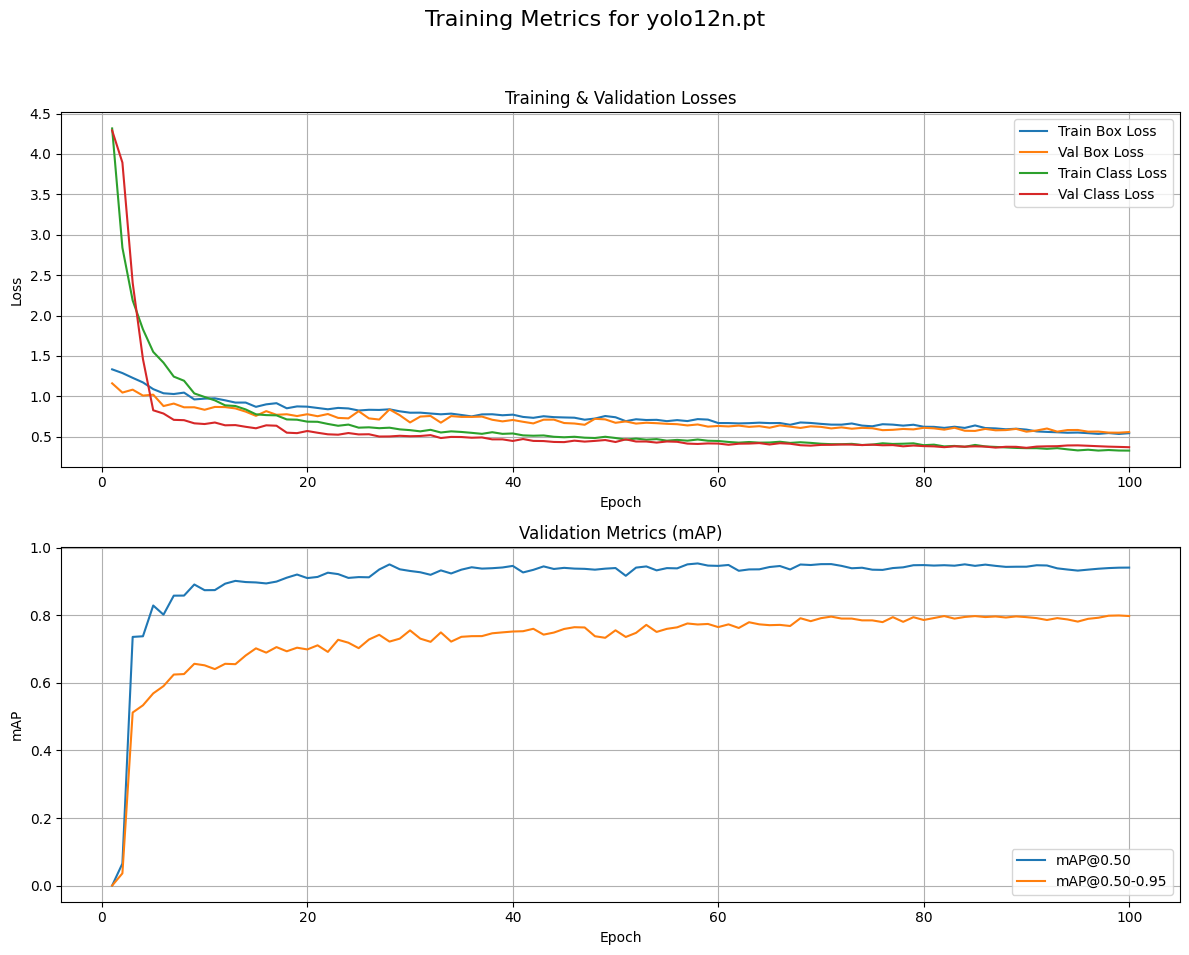

In [7]:
results_csv_path = os.path.join(RESULTS_PATH, 'results.csv')

try:
    df = pd.read_csv(results_csv_path)
    df.columns = df.columns.str.strip()

    print("Plotting mAP and Loss curves...")
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))
    fig.suptitle(f'Training Metrics for {MODEL_NAME}', fontsize=16)

    ax1.plot(df['epoch'], df['train/box_loss'], label='Train Box Loss')
    ax1.plot(df['epoch'], df['val/box_loss'], label='Val Box Loss')
    ax1.plot(df['epoch'], df['train/cls_loss'], label='Train Class Loss')
    ax1.plot(df['epoch'], df['val/cls_loss'], label='Val Class Loss')
    ax1.set_title('Training & Validation Losses')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True)

    ax2.plot(df['epoch'], df['metrics/mAP50(B)'], label='mAP@0.50')
    ax2.plot(df['epoch'], df['metrics/mAP50-95(B)'], label='mAP@0.50-0.95')
    ax2.set_title('Validation Metrics (mAP)')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('mAP')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

except FileNotFoundError:
    print(f"Error: Could not find results.csv at {results_csv_path}")
except Exception as e:
    print(f"An error occurred plotting: {e}")

Displaying Confusion Matrix...


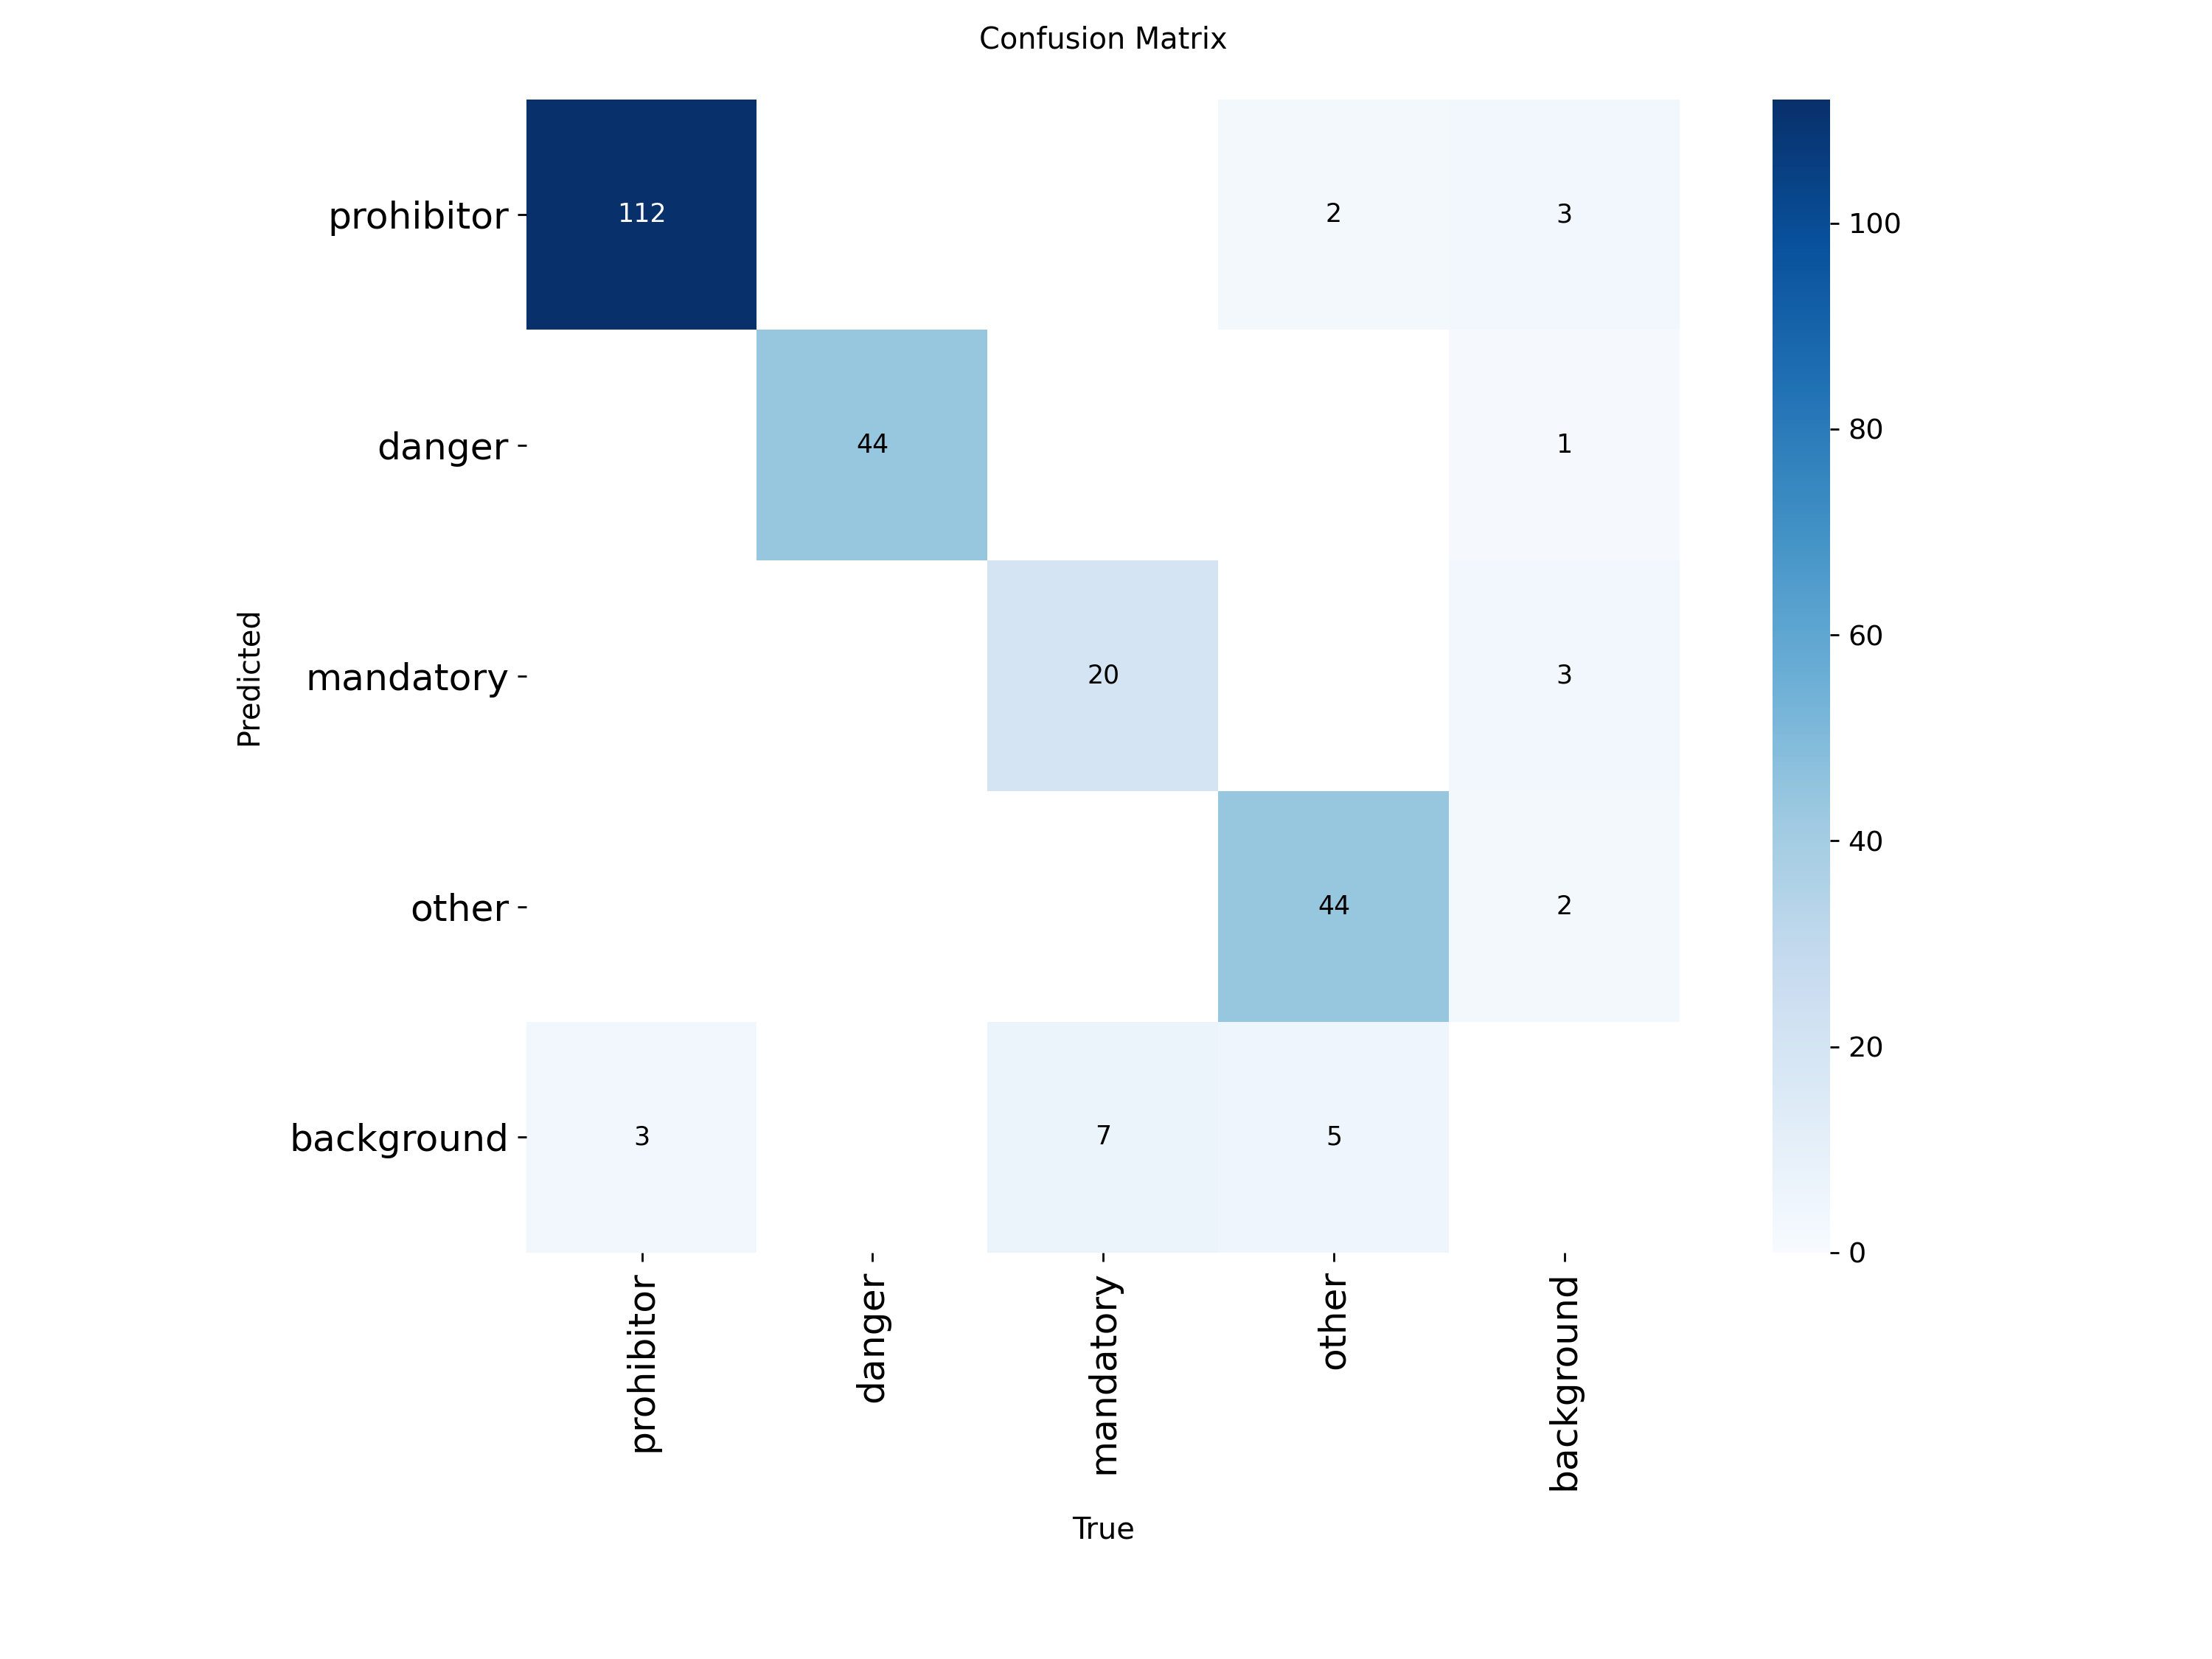

In [8]:
print("Displaying Confusion Matrix...")
cm_path = os.path.join(RESULTS_PATH, 'confusion_matrix.png')

if os.path.exists(cm_path):
    display(Image(filename=cm_path, width=800))
else:
    print(f"Could not find confusion matrix at {cm_path}")

Loading best model from /kaggle/working/runs/ts_detector/weights/best.pt...
Running inference on 5 random training images...

0: 384x640 2 prohibitors, 12.3ms
1: 384x640 3 prohibitors, 12.3ms
2: 384x640 2 mandatorys, 12.3ms
3: 384x640 2 others, 12.3ms
4: 384x640 1 mandatory, 12.3ms
Speed: 2.0ms preprocess, 12.3ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)
Results saved to /kaggle/working/runs/predict/ts_detector_test

Inference complete. Displaying results:


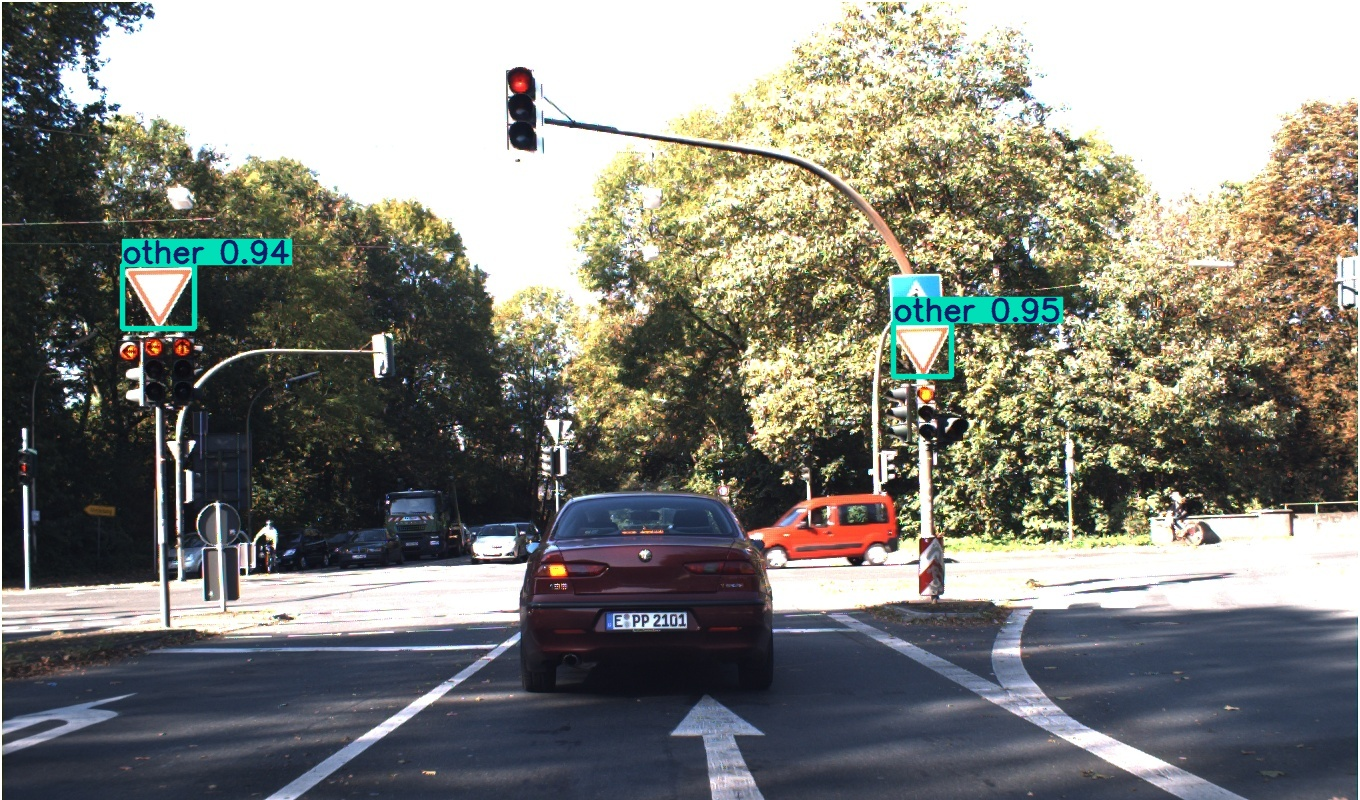

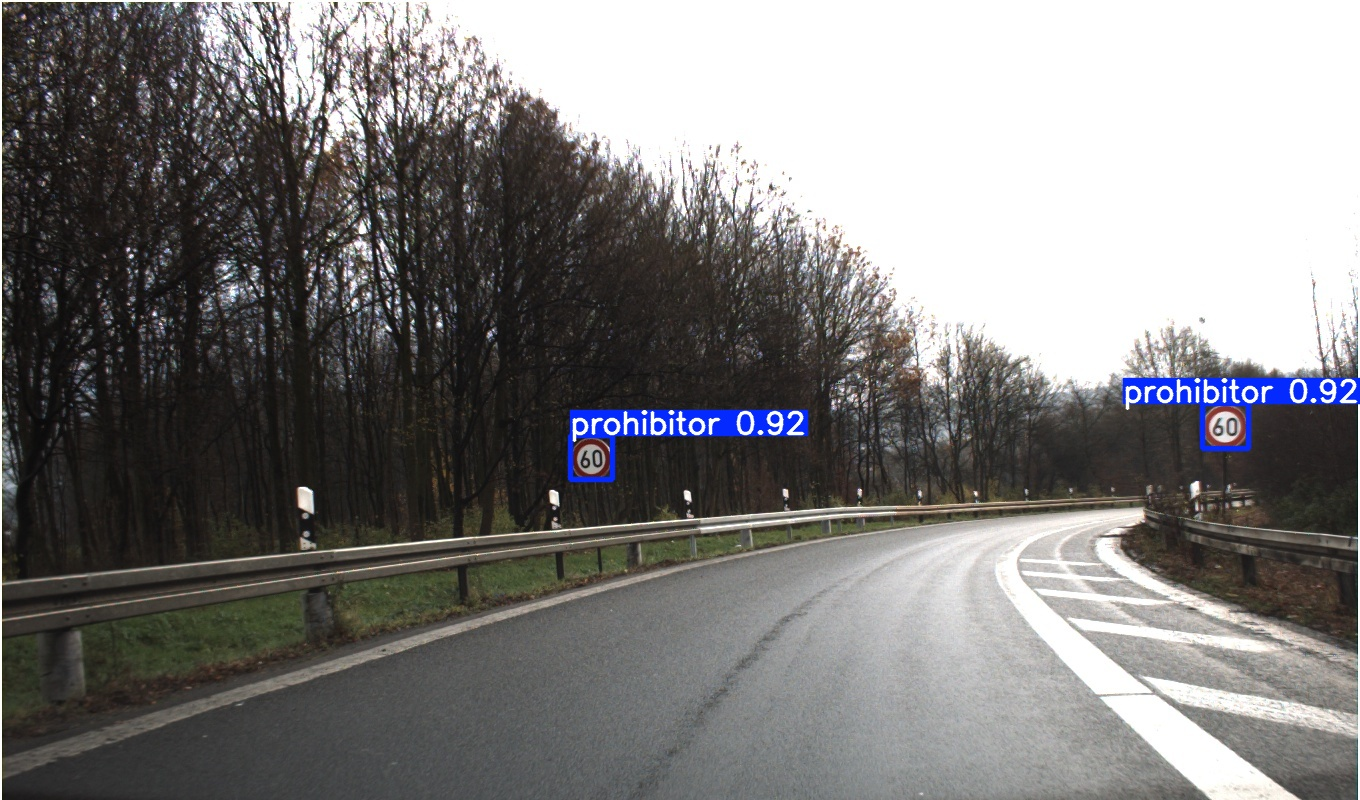

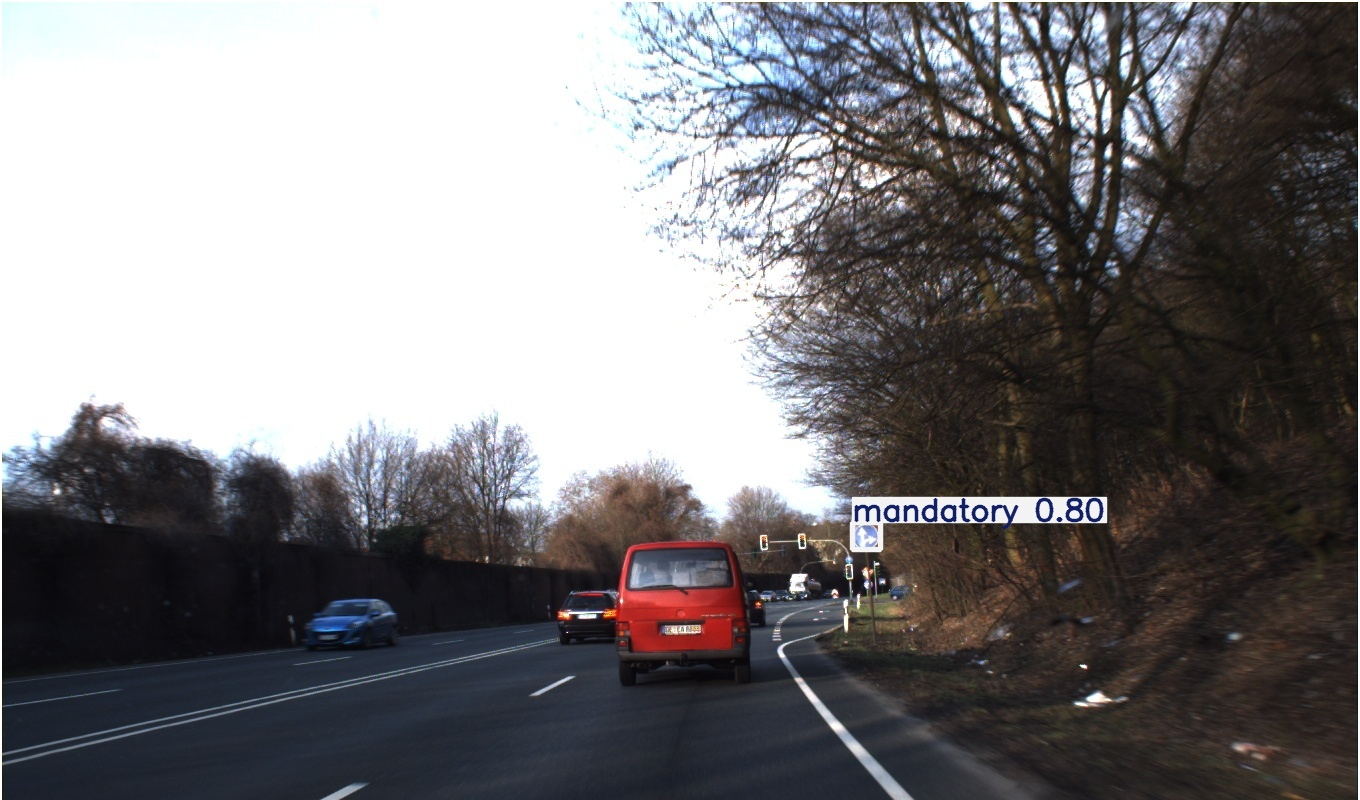

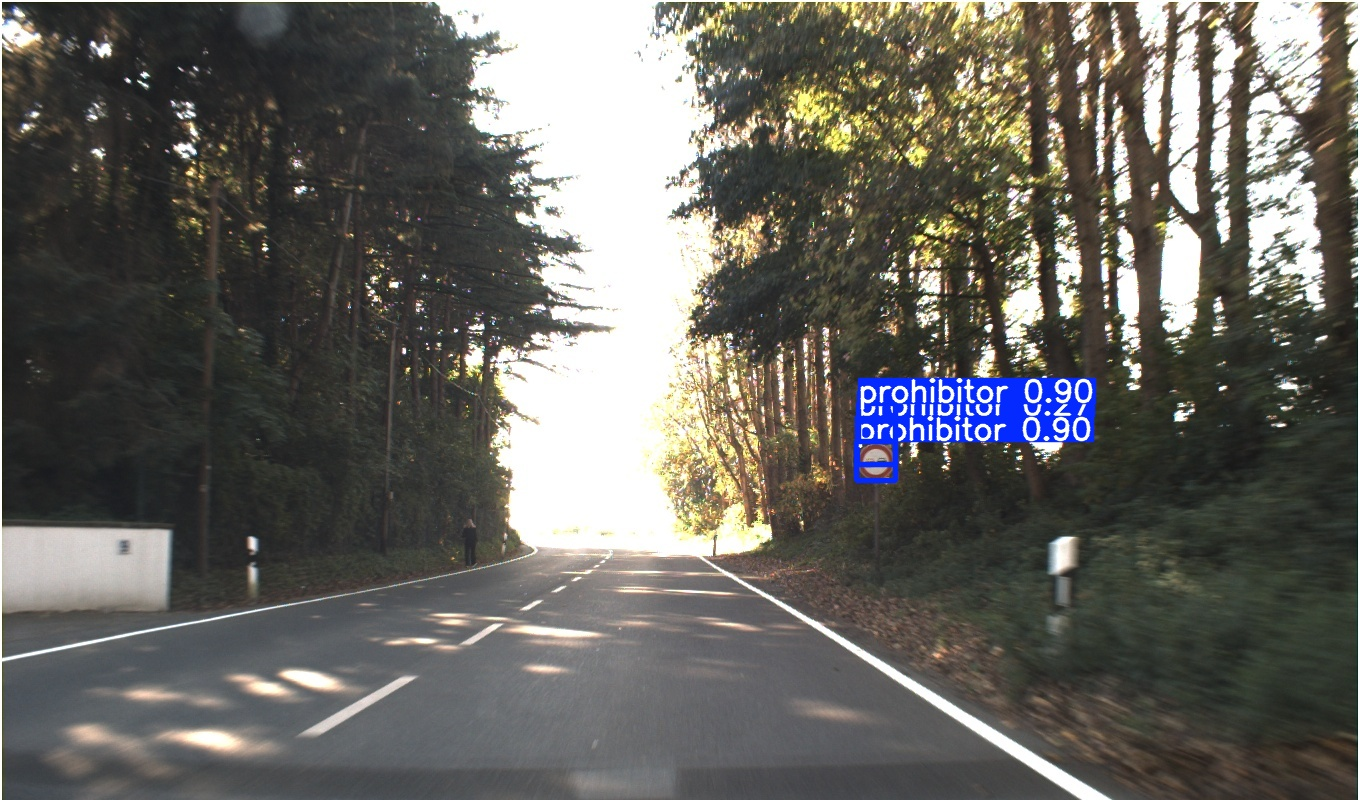

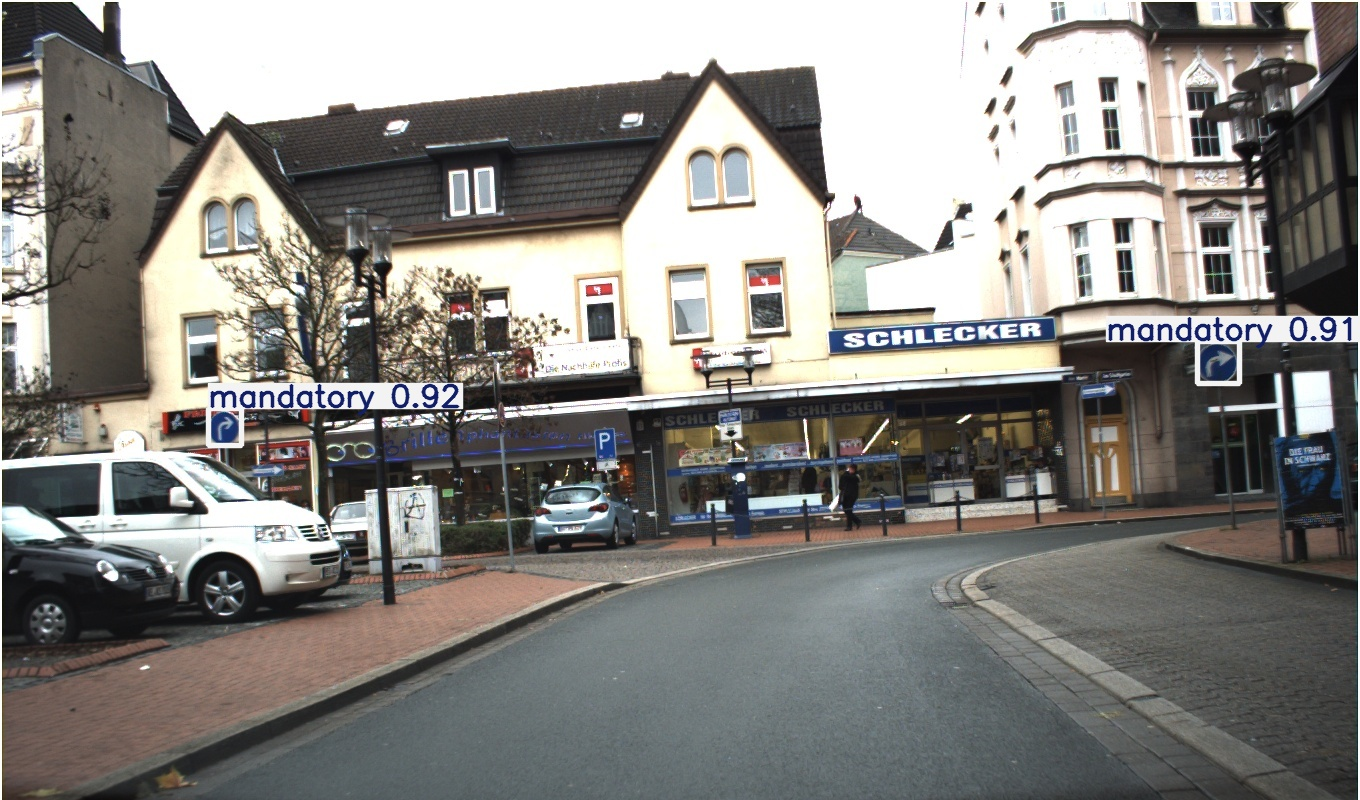

In [9]:
best_model_path = os.path.join(RESULTS_PATH, 'weights/best.pt')

if not os.path.exists(best_model_path):
    print("Error: best.pt model not found!")
else:
    print(f"Loading best model from {best_model_path}...")
    model = YOLO(best_model_path)

    train_image_paths = glob.glob(str(DATASET_DIR / 'images/train/*.jpg'))
    random.shuffle(train_image_paths)
    sample_images = train_image_paths[:5]

    print(f"Running inference on {len(sample_images)} random training images...")

    results = model.predict(
        source=sample_images, 
        save=True, 
        project='/kaggle/working/runs/predict', 
        name='ts_detector_test',
        exist_ok=True
    )

    print("\nInference complete. Displaying results:")

    saved_image_paths = glob.glob('/kaggle/working/runs/predict/ts_detector_test/*.jpg')
    for img_path in saved_image_paths:
        display(Image(filename=img_path))